In [45]:
from google.colab import drive
import numpy as np
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import pandas as pd
import gdown

file_path = '/content/drive/My Drive/FIT/Work_Space_Shot_Quality_Metric/Machine_Learning/tennis_MatchChartingProject-master/atp_cleaned_data.csv'
df = pd.read_csv(file_path)
df.head()

,player,forehand_winner_per,backhand_winner_per,forehand_unforced_error_per,backhand_unforced_error_per,net_per,net_point_direct_win_per,net_point_winning_per,net_point_error_per,passing_per,winner_per,err_per,pts_won_Ite_3_shots_per,shots_in_pts_won_per,shots_in_pts_lost_per,shots_in_won_vs_lost_ratio,inside_in_per,inside_out_per
0,Aaron Krickstein,4.99,3.69,7.72,8.90,9.03,31.96,5.21,42.65,12.25,25.510,28.176667,25.73,43.51,56.49,0.78,2.10,8.72
1,Adam Pavlasek,10.28,3.74,7.48,6.54,29.91,33.33,19.63,50.00,25.00,29.690,31.780000,30.82,60.00,40.00,1.50,2.15,12.37
2,Adrian Mannarino,4.95,3.48,9.87,7.11,11.77,46.86,7.72,53.49,11.81,24.208,33.811000,34.81,52.36,47.64,1.16,0.48,5.45
3,Adriano Panatta,8.19,5.17,9.05,7.76,46.98,34.00,21.55,50.46,6.00,33.000,34.480000,24.89,40.00,60.00,0.67,0.00,6.03
4,Agustin Calleri,10.80,6.82,11.36,15.91,27.84,60.71,15.91,53.06,0.00,43.750,44.890000,21.24,38.64,61.36,0.63,1.23,11.55


In [47]:
# #my (Michael's) own file path
# import pandas as pd
# import gdown
# file_path = '/content/drive/My Drive/Work_Space_Shot_Quality_Metric/Machine_Learning/tennis_MatchChartingProject-master/atp_cleaned_data.csv'
# df = pd.read_csv(file_path)
# df.head()

In [48]:
# # edit: add the serve won features and ace features
# df = df.drop(columns=["firstServeIn_per", "secondServeIn_per", "ace_per", "first_serve_won_per", "second_serve_won_per", "net_point_winByError_per"])

# Check for missing values in the dataset
# missing_values = df.isnull().sum()
# missing_values

In [49]:
# Drop the player column and prepare features
features = df.drop(columns=["player"])

# Fill missing values with the column mean
df = df.fillna(features.mean())

# Check for missing values in the dataset
missing_values = df.isnull().sum()
missing_values

,0
player,0
forehand_winner_per,0
backhand_winner_per,0
forehand_unforced_error_per,0
backhand_unforced_error_per,0
net_per,0
net_point_direct_win_per,0
net_point_winning_per,0
net_point_error_per,0
passing_per,0


In [50]:
# Check for inf or NaN in the dataset
problematic_rows = features[(features == np.inf) | (features == -np.inf) | (features.isna())].any(axis=1)
print(features[problematic_rows])

Empty DataFrame
Columns: [forehand_winner_per, backhand_winner_per, forehand_unforced_error_per, backhand_unforced_error_per, net_per, net_point_direct_win_per, net_point_winning_per, net_point_error_per, passing_per, winner_per, err_per, pts_won_Ite_3_shots_per, shots_in_pts_won_per, shots_in_pts_lost_per, shots_in_won_vs_lost_ratio, inside_in_per, inside_out_per]
Index: []


In [51]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

# Function to fit GMM and return categories and probabilities
def fit_gmm(n_components, data):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data)
    categories = gmm.predict(data)  # predicted categories
    probabilities = gmm.predict_proba(data)  # probabilities for each category
    return categories, probabilities

# Function to fit a "softer" GMM with regularization and tied covariance
def fit_gmm_soft(n_components, data, reg_covar=0.05, covariance_type='tied'):
    gmm = GaussianMixture(n_components=n_components, reg_covar=reg_covar, covariance_type=covariance_type, random_state=42)
    gmm.fit(data)
    categories = gmm.predict(data)  # predicted categories
    probabilities = gmm.predict_proba(data)  # probabilities for each category
    return categories, probabilities

In [52]:
from sklearn.preprocessing import StandardScaler

# Drop the player column and prepare features
features = df.drop(columns=["player"])

# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit the "softer" GMM with 4 components
gmm_4_categories, gmm_4_probabilities = fit_gmm_soft(4, scaled_features)

# Add the probabilities for each category (this will add 4 new columns to the DataFrame)
# Rescale the probabilities to be out of 100
for i in range(4):
    df[f'GMM_4_prob_category_{i+1}'] = gmm_4_probabilities[:, i] * 100

# Show the first few rows with the new classifications and probabilities
df[['player', 'GMM_4_prob_category_1', 'GMM_4_prob_category_2', 'GMM_4_prob_category_3', 'GMM_4_prob_category_4']].head(10)

,player,GMM_4_prob_category_1,GMM_4_prob_category_2,GMM_4_prob_category_3,GMM_4_prob_category_4
0,Aaron Krickstein,3.703907e-04,99.995334,4.289121e-03,6.446125e-06
1,Adam Pavlasek,3.403358e-07,8.876978,3.998631e-06,9.112302e+01
2,Adrian Mannarino,9.043304e-05,99.905192,9.470405e-02,1.348504e-05
3,Adriano Panatta,1.001937e-09,0.000120,8.597095e-11,9.999988e+01
4,Agustin Calleri,1.299238e-04,99.569118,3.369169e-01,9.383538e-02
5,Agustin Velotti,9.861076e-03,99.990100,3.603565e-05,2.744134e-06
6,Albert Montanes,4.358985e-01,99.564100,1.677426e-06,7.041380e-08
7,Albert Ramos,7.433600e-02,99.925415,2.487973e-04,3.213492e-07
8,Alberto Berasategui,9.945541e+01,0.544590,3.931330e-06,1.566890e-09
9,Alejandro Falla,6.778665e-06,99.907824,9.216169e-02,7.689609e-06


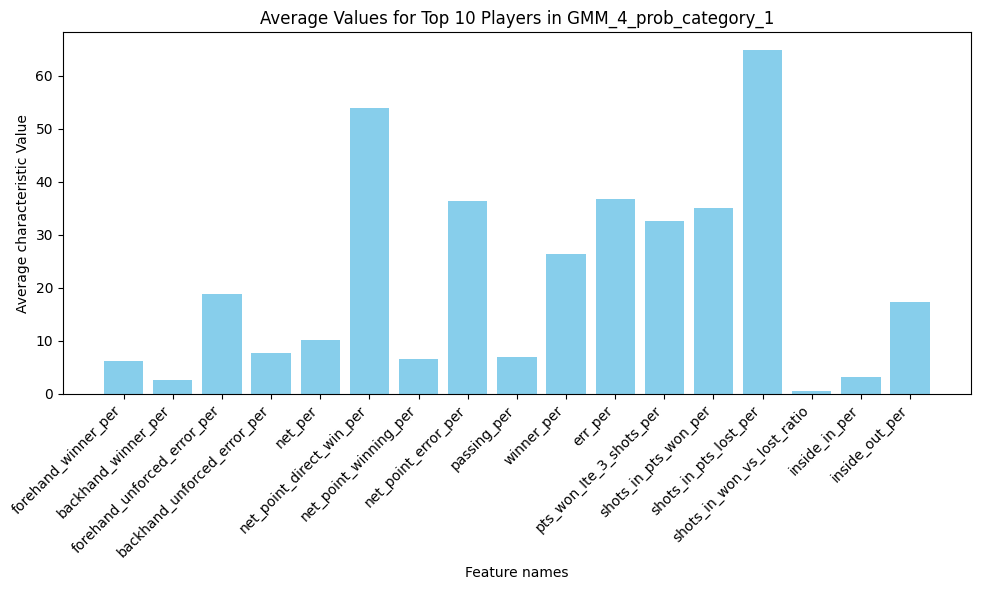

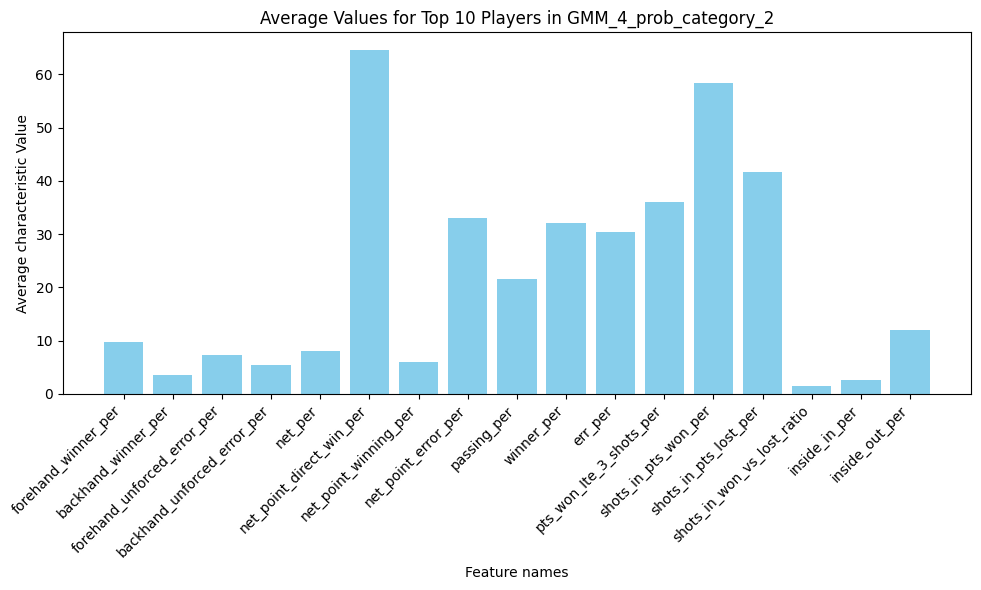

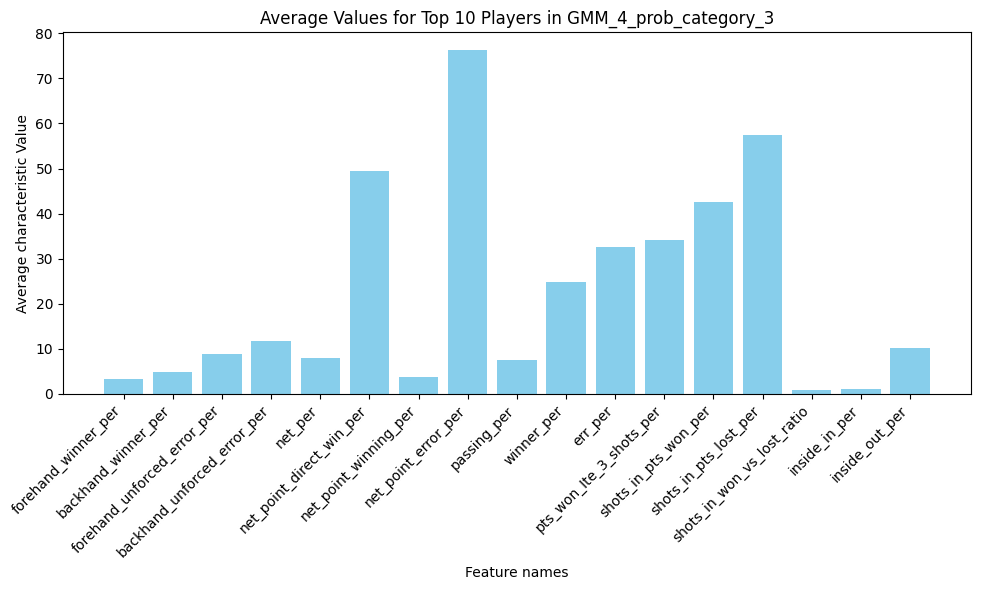

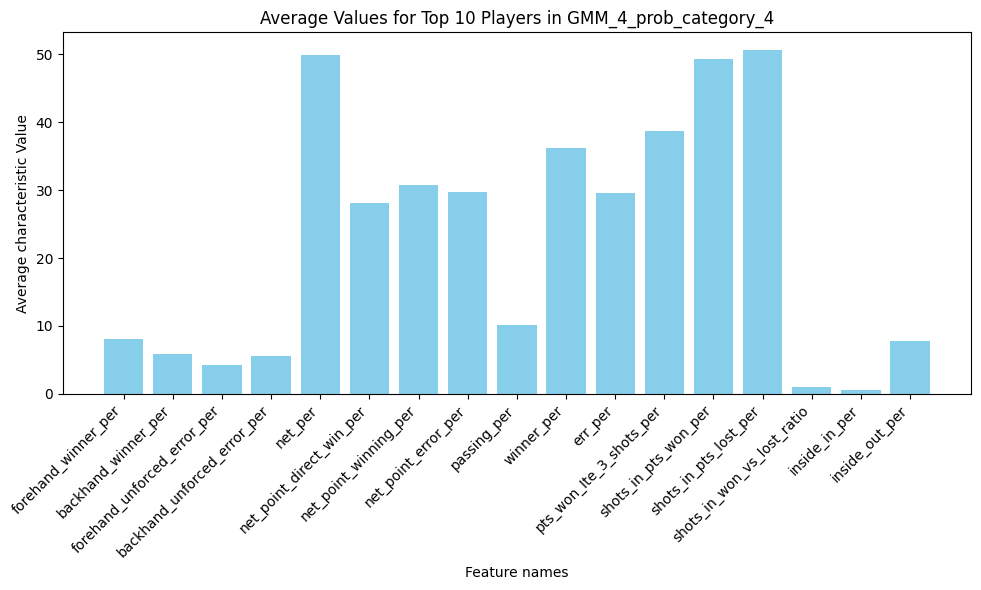

In [53]:
import matplotlib.pyplot as plt
# Define the columns to check for highest values
probability_columns = ['GMM_4_prob_category_1', 'GMM_4_prob_category_2', 'GMM_4_prob_category_3', 'GMM_4_prob_category_4']

# Features to include in the plot (as per the second image)
selected_features = [
    "forehand_winner_per", "backhand_winner_per", "forehand_unforced_error_per", "backhand_unforced_error_per",
    "net_per", "net_point_direct_win_per", "net_point_winning_per", "net_point_error_per", "passing_per",
    "winner_per", "err_per", "pts_won_Ite_3_shots_per", "shots_in_pts_won_per", "shots_in_pts_lost_per", "shots_in_won_vs_lost_ratio", "inside_in_per", "inside_out_per"
]

# Find and print only the names of the top 10 players for each specified feature
for column in probability_columns:
    top_10_players = df.sort_values(by=column, ascending=False).head(10)

    # Keep only the selected features
    top_10_players = top_10_players[selected_features]

    #print("\n")  # Add a new line for readability between categories
    column_averages=top_10_players.mean(numeric_only=True)
    #print(column_averages)
    #print("\n")
    plt.figure(figsize=(10, 6))
    plt.bar(column_averages.index, column_averages.values, color='skyblue')
    plt.title(f"Average Values for Top 10 Players in {column}")
    plt.xlabel("Feature names")
    plt.ylabel("Average characteristic Value")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


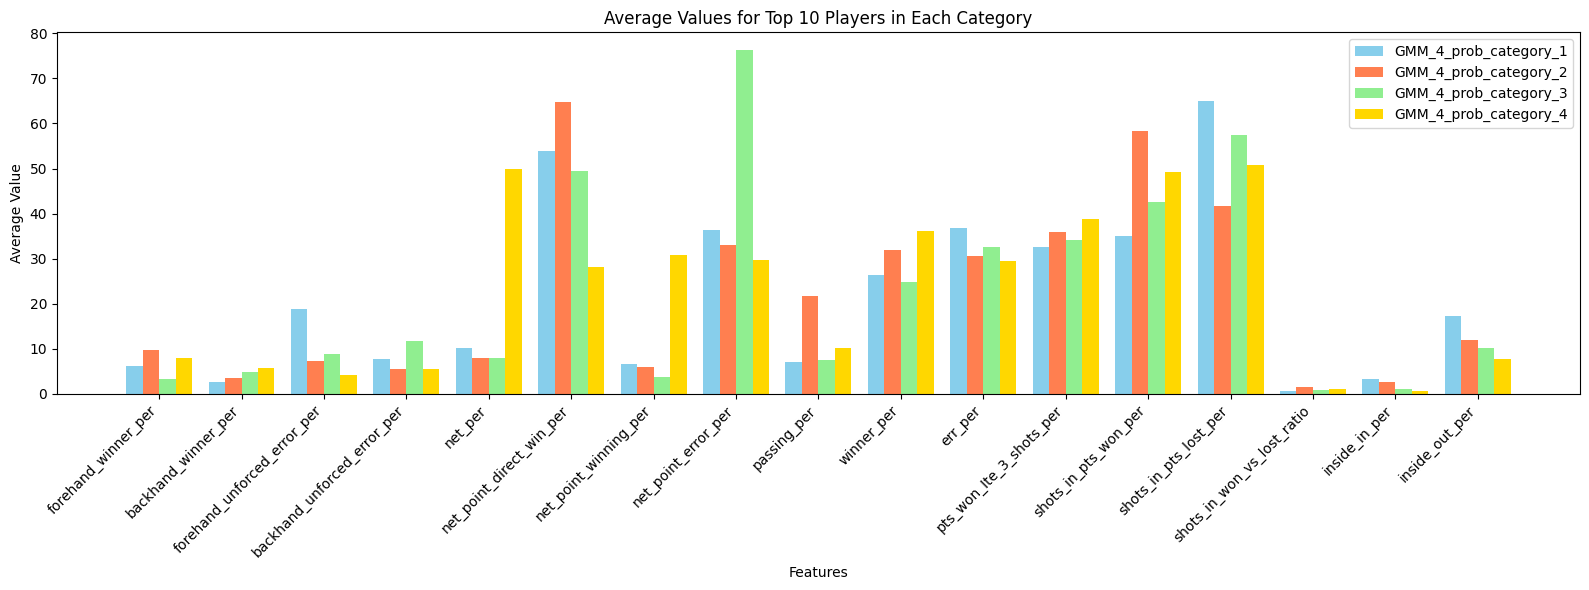

In [54]:
import numpy as np
import matplotlib.pyplot as plt

colors = ['skyblue', 'coral', 'lightgreen', 'gold']

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(16, 6))  # Adjust figure size as needed

# Width of each bar
bar_width = 0.2

# X positions for the bars
x_pos = None  # Declare the variable here for later use

# Loop through each probability column and plot the averages for selected features
for i, column in enumerate(probability_columns):
    top_10_players = df.sort_values(by=column, ascending=False).head(10)

    # Keep only the selected features
    top_10_players = top_10_players[selected_features]

    # Calculate the average values for the selected features
    column_averages = top_10_players.mean(numeric_only=True)

    # X positions for the bars
    if x_pos is None:  # Only calculate x_pos once
        x_pos = np.arange(len(column_averages.index))

    # Plot the bars
    ax.bar(x_pos + i * bar_width, column_averages, bar_width, color=colors[i], label=column)

# Set x-axis label, y-axis label, and title
ax.set_xlabel("Features")
ax.set_ylabel("Average Value")
ax.set_title("Average Values for Top 10 Players in Each Category")

# Set x-axis ticks and labels
ax.set_xticks(x_pos + bar_width * (len(probability_columns) / 2 -0.5))  # Center the x-axis labels
ax.set_xticklabels(column_averages.index, rotation=45, ha='right')

# Add a legend
ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [55]:
# Rename the probability columns to reflect the new play style categories
df.rename(columns={
    'GMM_4_prob_category_1': 'Counter Puncher',
    'GMM_4_prob_category_2': 'Attacking Baseliner',
    'GMM_4_prob_category_3': 'All-Court Player',
    'GMM_4_prob_category_4': 'Solid Baseliner'
}, inplace=True)

# Display the updated DataFrame with new column names
df[['player', 'Counter Puncher', 'Attacking Baseliner', 'All-Court Player', 'Solid Baseliner']].sample(n=10, random_state=42)


,player,Counter Puncher,Attacking Baseliner,All-Court Player,Solid Baseliner
219,Marin Cilic,8.102882e-05,9.999929e+01,6.232063e-04,0.000007
42,Brian Teacher,6.196078e-17,1.390027e-09,1.092560e-19,100.000000
211,Marcel Granollers,3.336919e-04,9.999637e+01,2.973333e-04,0.003004
193,Lleyton Hewitt,3.794491e-06,9.998140e+01,1.858335e-02,0.000012
56,Damir Dzumhur,1.287524e-04,9.970602e+01,2.937022e-01,0.000148
179,Julien Benneteau,4.353579e-06,9.999955e+01,3.965898e-04,0.000051
15,Alexander Bublik,2.350123e-08,9.998388e+01,4.192010e-04,0.015696
57,Dan Goldie,4.012579e-13,3.132428e-06,3.047797e-14,99.999997
139,Ivan Ljubicic,1.673764e-06,9.982983e+01,1.701080e-01,0.000064
148,Jannik Sinner,7.337830e-05,9.999819e+01,1.702964e-03,0.000030


In [56]:
output_file_path = '/content/drive/MyDrive/FIT/Work_Space_Shot_Quality_Metric/Machine_Learning/gmm_clustering_with_play_styles.csv'
df.to_csv(output_file_path, index=False)

<ipython-input-57-8b6c5146afe2>:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_features[indices, 0], pca_features[indices, 1],


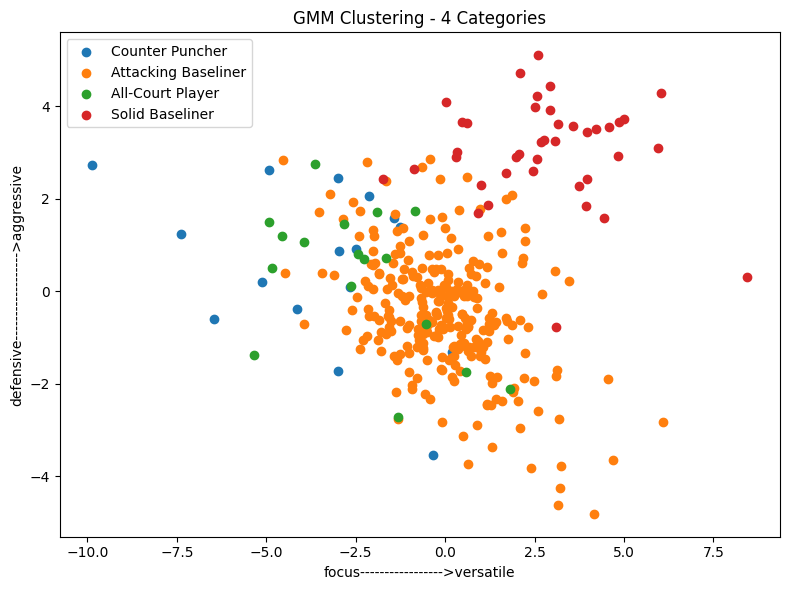

In [57]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Create a figure for the visualization
plt.figure(figsize=(8, 6))

# Define category names (replace with your actual category names)
category_names = ['Counter Puncher', 'Attacking Baseliner', 'All-Court Player', 'Solid Baseliner']

# Scatter plot for each category with labels
for category in range(4):  # Assuming 4 categories
    indices = np.where(gmm_4_categories == category)  # Find indices for each category
    plt.scatter(pca_features[indices, 0], pca_features[indices, 1],
                label=category_names[category], cmap='plasma')

plt.title('GMM Clustering - 4 Categories')
#refering to the text interpretation below: the main difference between all court player and solid baseliner is versatility and tactical flexibility
plt.xlabel('focus----------------->versatile')
#same reference: the main difference between attacking baseliner and counter puncher is aggressive style vs transition from defensive to offensive
plt.ylabel('defensive------------------>aggressive')

# Add colorbar
#plt.colorbar(scatter)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

the orange dots are all court players. The purple dots are attacking baseliner. The dark blue dots are counter puncher. The yellow dots are solid baseliner.

In [58]:
import numpy as np
from sklearn.model_selection import KFold
x=scaled_features
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
best_gmm=None
best_score=-np.inf
for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    gmm=GaussianMixture(n_components=4, random_state=42)
    gmm.fit(x_train)
    score=gmm.score(x_test)
    if score>best_score:
        best_score=score
        best_gmm=gmm
    print(f"Fold Score: {score}")
print(f"Best Score: {best_score}")


Fold Score: -11.829081580836625
Fold Score: -14.51004539924145
Fold Score: -12.225023919505366
Fold Score: -11.93898617378539
Fold Score: -15.25887734210045
Best Score: -11.829081580836625
